#Sandbox
For playing around during development.

Todo:

- check that lookup table data is bound to the instance, not to the class

In [2]:
%pylab inline
import pysd
print pysd.__version__
print pysd.__file__

Populating the interactive namespace from numpy and matplotlib
0.3.0
pysd/__init__.pyc


In [2]:
model = pysd.read_vensim('tests/vensim/Teacup.mdl')

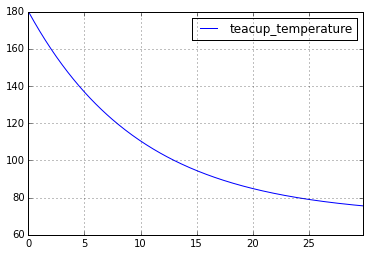

In [3]:
model.run().plot()

In [8]:
stocks = model.run(return_timestamps=range(30))

In [10]:
all(stocks.index.values == np.array(range(30)))

True

Lets plot the history of our speedup efforts:

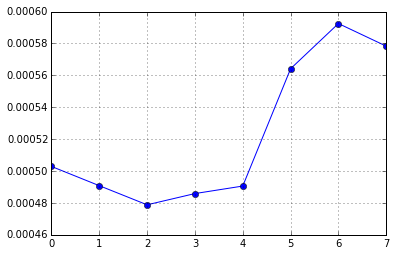

In [12]:
import pandas as pd

dictlist = []
with open('tests/speedtest_results.json') as infile:
    for line in infile:
        dictlist.append(eval(line))
    
speedtests = pd.DataFrame(dictlist)
speedtests['run teacup baseline'].plot(marker='o');